# GPT model configuration

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,  # Context length, maximum number of tokens.
    "emb_dim": 768,  # Embedding dimension (d_in = d_out)
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-Key-Value bias
}

# Placeholder GPT Model (Backbone)

1. Uses a placeholder for TransformerBlock
2. Uses a placeholder for LayerNorm
3. A simple placeholder class that will be replaced by a real TransformerBlock later
4. This block does nothing and just returns its input.
5. A simple placeholder class that will be replaced by a real LayerNorm later
6. The parameters here are just to mimic the LayerNorm interface.”

In [3]:
import torch
from torch import nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(  # 1
            *[
                DummyTransformerBlock(cfg)  # 1
                for _ in range(cfg["n_layers"])
            ]  # 1
        )  # 1
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])  # 2
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        # tok_embeds: batch_size * seq_len * emb_dim
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        # x: batch_size * seq_len * emb_dim
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        # logits: batch_size * seq_len * vocab_size
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):  # 3
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):  # 4
        return x


class DummyLayerNorm(nn.Module):  # 5
    def __init__(self, normalized_shape, eps=1e-5):  # 6
        super().__init__()

    def forward(self, x):
        return x

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


# Layer Normalization

In [6]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)  # 1
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out.shape)
print(out)
var, mean = torch.var_mean(out, dim=1, keepdim=True)
print("Mean:", mean)
print("Variance:", var)

torch.Size([2, 6])
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<VarMeanBackward0>)
Variance: tensor([[0.0231],
        [0.0398]], grad_fn=<VarMeanBackward0>)


In [7]:
out_norm = (out - mean) / torch.sqrt(var)
var2, mean2 = torch.var_mean(out_norm, dim=1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean2)
print("Variance:\n", var2)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[4.9671e-08],
        [1.5212e-08]], grad_fn=<VarMeanBackward0>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarMeanBackward0>)


In [8]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, correction=0)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [9]:
ln = LayerNorm(5)  # nn.LayerNorm(5) will do the same.

out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, correction=0, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
ln = nn.LayerNorm(5)  # show that it does the same.

out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, correction=0, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-3.5763e-08],
        [ 2.3842e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# GELU activation

In [11]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return (
            0.5
            * x
            * (
                1
                + torch.tanh(
                    torch.sqrt(torch.tensor(2.0 / torch.pi))
                    * (x + 0.044715 * torch.pow(x, 3))
                )
            )
        )


# There is also `nn.GELU`. Use approximate="tanh" for the tanh approximation.
# Otherwise, it would be exact.
nn.GELU(approximate="tanh")

GELU(approximate='tanh')

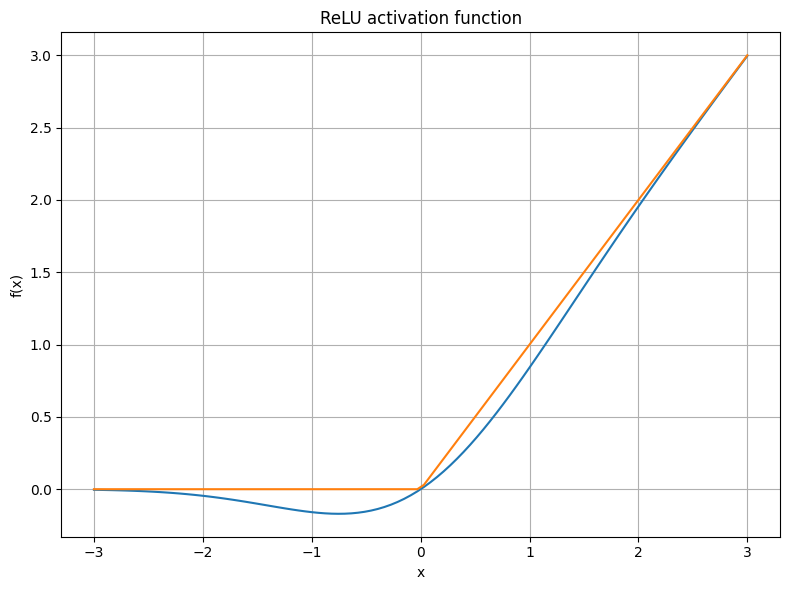

In [12]:
import matplotlib.pyplot as plt

gelu, relu = nn.GELU(approximate="none"), nn.ReLU()

x = torch.linspace(-3, 3, 100)  # 1
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 6))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.plot(x, y, label=label)

plt.grid(True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title(f"{label} activation function")
plt.tight_layout()
plt.show()

In [13]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

# Shortcut connections

In [14]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList(
            [  # 1
                nn.Sequential(nn.Linear(s0, s1), GELU())
                for (s0, s1) in zip(layer_sizes, layer_sizes[1:])
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)  # 2
            if self.use_shortcut and x.shape == layer_output.shape:  # 3
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    output = model(x)  # 1
    target = torch.tensor([[0.0]])

    loss = nn.MSELoss()
    loss = loss(output, target)  # 2

    loss.backward()  # 3

    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [15]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1.0, 0.0, -1.0]])
torch.manual_seed(123)  # 1
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [16]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [17]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


# Transformer Block
 #1


In [18]:
from llm_from_scratch.c3 import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"],
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x  # 1
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # 2

        shortcut = x  # 3
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # 4
        return x

In [19]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)  # 1
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


# Final GPT Model

In [21]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)  # 1
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [22]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [24]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [25]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(
    f"Number of trainable parameters "
    f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


In [26]:
total_size_bytes = total_params * 4  # 1
total_size_mb = total_size_bytes / (1024 * 1024)  # 2
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


| Model | Embedding Dim | # Transformers | # Attention Head | 
| -- | -- | -- | -- |
| GPT-2 small | 768 | 12  | 12 | 
| GPT-2 medium | 1024 | 24 | 16 |
| GPT-2 large | 1280 | 36 | 20 |
| GPT-2 2XL | 1600 | 48 | 25 |

All have

| Param | Value | 
| -- | -- |
| Context size | 1024 | 
| Vocab size | 50257 | 



# Logit to Vocab

**Greedy Decoding**

Run softmax on last logit, then grab the entry with largest probability. **Actually you don't even need this since softmax is monotonic, just grab the highest logit**.

For training, we use `torch.CrossEntropy()`. You cannot just subtract like regression, cross entropy is the proper mathematical loss for comparing two probabilities.

| Loss Function | Use Case |
| -- | -- |
| `torch.MSELoss` | Regression |
| `torch.CrossEntropy` | Classification |


In [ ]:
def generate_text_simple(  # 1
    model, idx, max_new_tokens, context_size
):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # 2
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]  # 3
        probas = torch.softmax(logits, dim=-1)  # 4
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # 5
        idx = torch.cat((idx, idx_next), dim=1)  # 6

    return idx

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # 1
print("encoded_tensor.shape:", encoded_tensor.shape)

In [31]:
x = torch.rand(2, 3)
y = x.unsqueeze(0)
z = x.view(1, 2, 3)

print(y.shape)
print(z.shape)
print(torch.allclose(x, y))

torch.Size([1, 2, 3])
torch.Size([1, 2, 3])
